In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import glob
pa = glob.glob("crosslogs/lightning_logs/version_15/checkpoints/last.ckpt")[-1]

In [3]:
pa

'crosslogs/lightning_logs/version_15/checkpoints/last.ckpt'

In [4]:
from model.crossmodal.main import Model, params

In [5]:
model = Model(params)
model.test_input()

input
torch.Size([64, 1, 36, 40])
torch.Size([64, 3, 32, 32])
encoder out mean_shape
torch.Size([64, 1, 36, 40])


In [6]:
model = model.load_from_checkpoint(pa)
model.eval()

Model(
  (ue): UttrEncoder(
    (model): ModuleDict(
      (lr): GLU()
      (conv1a): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False, padding_mode=replicate)
      (bn1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1b): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False, padding_mode=replicate)
      (bn1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2a): Conv2d(16, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False, padding_mode=replicate)
      (bn2a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2b): Conv2d(16, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False, padding_mode=replicate)
      (bn2b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3a): Conv2d(32, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), b

# eval

In [7]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [8]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [9]:
x = torchaudio.load(wav_paths.collect_files()[351])[0]
tmp = torchaudio.load(wav_paths.collect_files()[651])[0]
print(x.shape)
print(tmp.shape)

torch.Size([1, 216260])
torch.Size([1, 205179])


In [10]:
from data.dataset import ImageDataset
idatasets = ImageDataset(root="data/images")

In [11]:
y = idatasets[0]
y2 = idatasets[1]
y3 = idatasets[2]

/work/kenya/splitternet/data/dataset.py:169: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.random.choice(self.data[label][index])
/work/kenya/splitternet/data/dataset.py:169: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(self.data[label][index])


In [12]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=35, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [13]:
def synth(mc, f0, ap):
    f0 = f0[:mc.shape[1]]
    ap = ap[:mc.shape[1]]
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    return pw.synthesize(f0, sp, ap, 24000)

In [14]:
x_mc, x_f0, x_sp, x_ap = ex_mc(x)
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)

In [15]:
print(x_mc.shape)

torch.Size([36, 1803])


## 元音声の再合成

In [16]:
xx = synth(x_mc, x_f0, x_ap)

In [17]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

/tmp/ipykernel_1854159/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


(1, 216360)


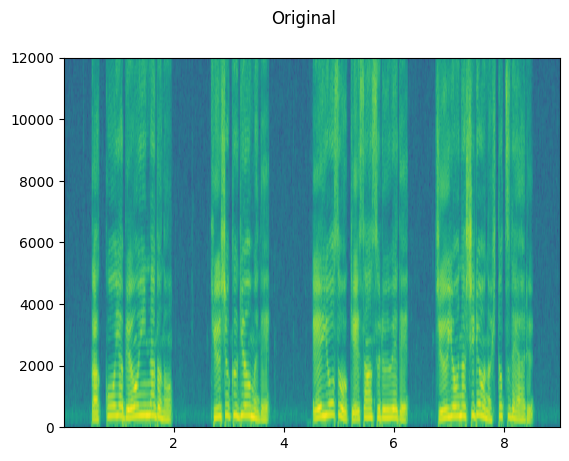

In [18]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [19]:
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

In [20]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 205200)


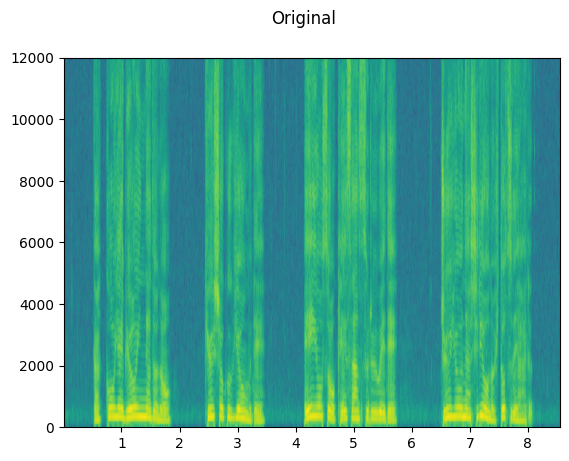

In [21]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [22]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y3.unsqueeze(0)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [23]:
yy = synth(y_mc, x_f0*0.95, x_ap)
yy = yy[2000:-2000]

In [24]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 212000)


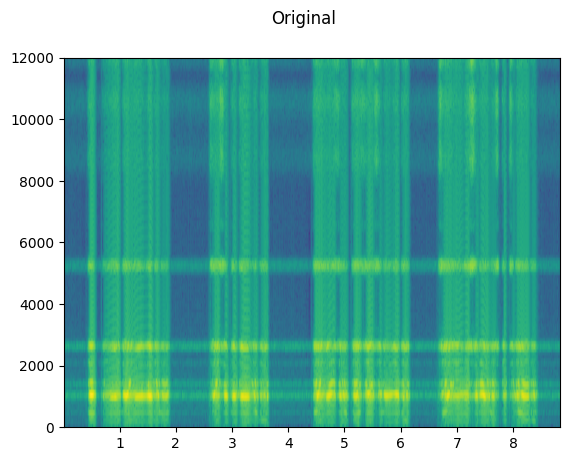

In [25]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

In [26]:
y_mc = model(tmp_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [27]:
yy = synth(y_mc, tmp_f0*1.05, tmp_ap)
yy = yy[2000:-2000]

In [28]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 200960)


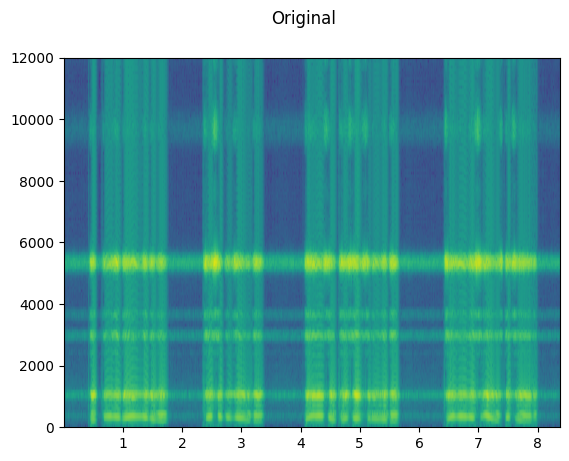

In [29]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

## 画像の再構成確認

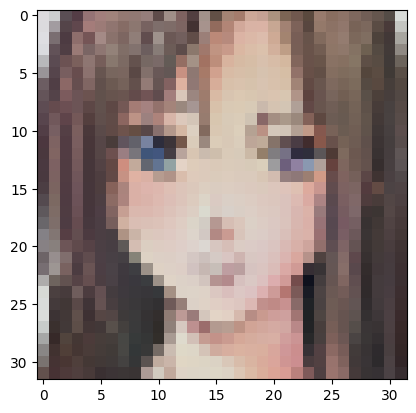

In [30]:
plt.imshow(y3.to(torch.uint8).permute(1, 2, 0))

In [31]:
yy = model.rc_image(y3.unsqueeze(0))

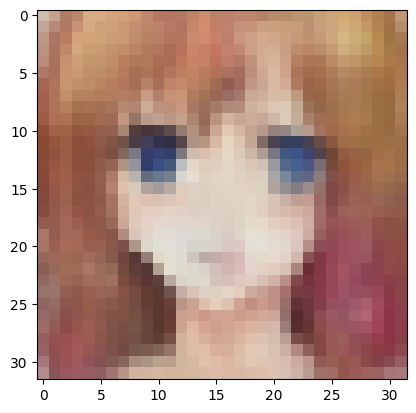

In [32]:
plt.imshow(yy.permute(1, 2, 0))

In [33]:
yy_hat = model.speech_to_face(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y3.unsqueeze(0))

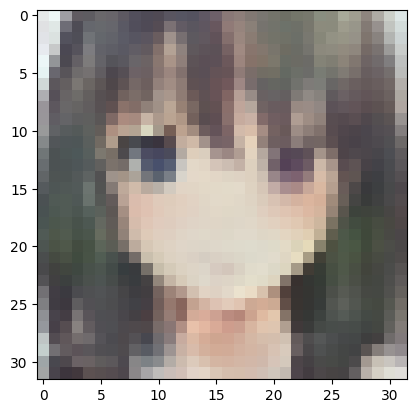

In [34]:
plt.imshow(yy_hat.permute(1, 2, 0))

# メルケプストラム歪み

In [35]:
import librosa
from nnmnkwii.metrics import melcd

def calc_melcd(a_mcs, b_mcs):
    m = []
    for a, b in zip(a_mcs, b_mcs):
        min_cost, wp = librosa.sequence.dtw(a[1:, :], b[1:, :])
        m.append(melcd(a[:, wp[:,0]], b[:, wp[:,1]] , lengths=None)/len(wp))
    return sum(m)/len(m)

In [37]:
a = tmp_mc.numpy()
b = y_mc.numpy()
calc_melcd([a], [b])

0.08685964613192808

In [67]:
class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.
    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta=0.5):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
    
    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j
        z (continuous) -> z_q (discrete)
        z.shape = (batch, channel, height, width)
        quantization pipeline:
            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)
        """
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(self.device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight)

        return z_q

    def loss(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j
        z (continuous) -> z_q (discrete)
        z.shape = (batch, channel, height, width)
        quantization pipeline:
            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)
        """
        
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(self.device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        return loss, z_q, perplexity, min_encodings, min_encoding_indices

In [69]:
vec = VectorQuantizer(n_e=512, e_dim=8)

In [70]:
inp = torch.zeros(128, 8)